In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pycaret
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from feature_engine.outliers import Winsorizer

from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor

In [2]:
print(tf.__version__)

2.16.1


In [3]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [4]:
train.head()

,brand,price,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,Toyota,564800000.0,Mobil Baru,2024.0,5.0,4.0,Complete Built Up (CBU),2982.0,134.0,300.0,Direct Injection,Turbocharged,5380.0,1880.0,3110.0
1,Toyota,408400000.0,Mobil Baru,2024.0,5.0,5.0,Complete Knock Down (CKD),1987.0,172.0,205.0,Direct Injection,Aspirated,4755.0,1850.0,2850.0
2,Toyota,290550000.0,Mobil Baru,2024.0,5.0,5.0,Complete Knock Down (CKD),1496.0,103.0,136.0,Multi-Point Injection,Aspirated,4435.0,1695.0,2685.0
3,Toyota,146000000.0,Mobil Bekas,2017.0,80.0,5.0,Complete Knock Down (CKD),1329.0,95.0,121.0,Multi-Point Injection,Aspirated,4190.0,1660.0,2655.0
4,Hyundai,298000000.0,Mobil Bekas,2022.0,55.0,5.0,Complete Knock Down (CKD),1497.0,113.0,144.0,Multi-Point Injection,Aspirated,4315.0,1790.0,2610.0


In [5]:
test.head()

,brand,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,Wuling,Mobil Baru,2023.0,5.0,5.0,Complete Knock Down (CKD),1485.0,105.0,143.0,Multi-Point Injection,Aspirated,4350.0,1750.0,2550.0
1,Suzuki,Mobil Bekas,2022.0,35.0,5.0,Complete Knock Down (CKD),1462.0,103.0,138.0,Multi-Point Injection,Aspirated,4450.0,1775.0,2740.0
2,Toyota,Mobil Bekas,2013.0,140.0,5.0,Complete Knock Down (CKD),1998.0,134.0,182.0,Multi-Point Injection,Aspirated,4585.0,1760.0,2750.0
3,Hyundai,Mobil Baru,2024.0,5.0,5.0,Complete Knock Down (CKD),1497.0,113.0,144.0,Multi-Point Injection,Aspirated,4495.0,1815.0,2780.0
4,Hyundai,Mobil Baru,2024.0,5.0,5.0,Complete Built Up (CBU),2151.0,200.0,440.0,Direct Injection,Turbocharged,4785.0,1900.0,2765.0


In [6]:
encoder = LabelEncoder()

def handle_encoding(df, method, columns):
    for column in columns:
        df[column] = method.fit_transform(df[column])

    return df

In [7]:
features = ['brand', 'Kondisi', 'Dirakit', 'InjeksiLangsung', 'Aspirasi']

handle_encoding(train, encoder, features)
handle_encoding(test, encoder, features)

,brand,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,38,0,2023.0,5.0,5.0,2,1485.0,105.0,143.0,1,0,4350.0,1750.0,2550.0
1,34,1,2022.0,35.0,5.0,2,1462.0,103.0,138.0,1,0,4450.0,1775.0,2740.0
2,36,1,2013.0,140.0,5.0,2,1998.0,134.0,182.0,1,0,4585.0,1760.0,2750.0
3,12,0,2024.0,5.0,5.0,2,1497.0,113.0,144.0,1,0,4495.0,1815.0,2780.0
4,12,0,2024.0,5.0,5.0,1,2151.0,200.0,440.0,0,1,4785.0,1900.0,2765.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,38,0,2024.0,5.0,3.0,2,1498.0,118.0,145.0,1,0,2974.0,1505.0,2010.0
2540,36,1,2013.0,5.0,5.0,2,1495.0,107.0,141.0,1,0,4420.0,1745.0,2685.0
2541,12,0,2024.0,5.0,5.0,2,1497.0,113.0,144.0,1,0,4315.0,1790.0,2610.0
2542,23,1,2017.0,45.0,5.0,1,1997.0,149.0,190.0,0,0,4715.0,1770.0,2850.0


<Axes: >

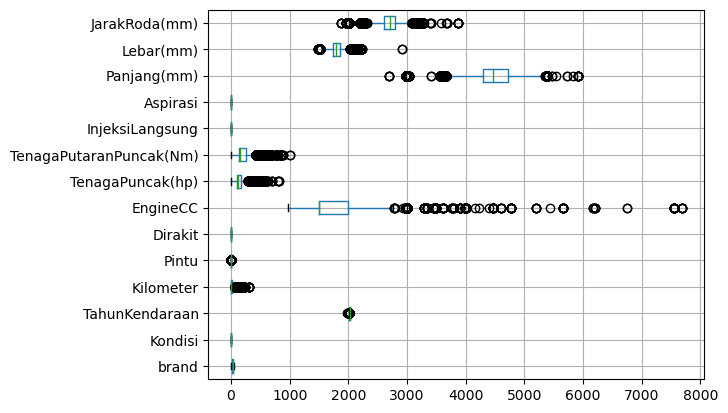

In [8]:
train.drop(columns='price').boxplot(vert=False)

In [9]:
windsorizer = Winsorizer(
    capping_method="iqr",
    tail="both",
    fold=1.5,
    variables=["JarakRoda(mm)", "Lebar(mm)", "Panjang(mm)", "TenagaPutaranPuncak(Nm)", "TenagaPuncak(hp)", "EngineCC", "Kilometer", "price"],
)

In [10]:
def winsorize(df):    
    df = windsorizer.fit_transform
    
winsorize(train)
winsorize(test)

In [11]:
X = train.drop(columns='price')
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [13]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [20]:
def make_model(model):
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    return f1_score(preds, y_test)

In [15]:
X_test

,brand,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,0.911111,1.0,0.956522,0.118644,1.000000,0.666667,0.156350,0.164417,0.178894,1.0,0.0,0.633540,0.484311,0.443051
1,0.911111,0.0,1.000000,0.000000,1.000000,0.666667,0.271483,0.242945,0.496482,0.0,1.0,0.652174,0.518417,0.440542
2,0.622222,0.0,0.978261,0.000000,0.666667,0.333333,0.156502,0.020859,0.195980,0.0,1.0,0.638509,0.470668,0.500753
3,0.911111,1.0,0.891304,0.271186,1.000000,0.666667,0.080000,0.122699,0.131658,1.0,0.0,0.540373,0.300136,0.410437
4,0.511111,1.0,0.934783,0.033898,1.000000,0.333333,0.378099,0.359509,0.357789,1.0,0.0,0.728261,0.511596,0.568490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,0.333333,0.0,1.000000,0.000000,1.000000,0.666667,0.080152,0.134969,0.139698,1.0,0.0,0.559006,0.463847,0.458103
2031,0.311111,1.0,0.869565,0.186441,0.666667,0.333333,0.080304,0.208589,0.216080,0.0,1.0,0.600932,0.818554,0.417963
2032,0.333333,0.0,1.000000,0.000000,1.000000,0.666667,0.080152,0.134969,0.139698,1.0,0.0,0.548137,0.416098,0.458103
2033,0.911111,0.0,1.000000,0.000000,1.000000,0.666667,0.034525,0.103067,0.103518,1.0,0.0,0.439441,0.245566,0.330156


In [21]:
xgb = XGBRegressor()

make_model(xgb)

ValueError: continuous is not supported

In [17]:
ridge = Ridge()

make_model(ridge)

2.9832796832063066e+17

In [18]:
lasso = Lasso()

make_model(lasso)

3.0699901707026995e+17